## Sliding time window
La ventana de tiempo deslizante a implementar consta de ...

### Imports

In [12]:
import numpy as np
import pandas as pd
from scipy import stats as st
import plotly.graph_objects as go
from tqdm import tqdm

### Load data

In [13]:
df_train = pd.read_csv('./filtered_data/smartphone_02-Feb-2022-20-04_frenada repentina_Data-Mv2FX62bOlZJlm8VJJx.csv')
df_test = pd.read_csv('./filtered_data/smartphone_02-Feb-2022-20-01_frenada repentina_Data-Mv2EUSpYPrGpMG3qjaD.csv')


print("Train data size: ", df_train.shape)
print("Near crash event data size: ", df_train["eventClass"][df_train["eventClass"] == 1].shape)
print("No near crash event data size: ", df_train["eventClass"][df_train["eventClass"] == 0].shape)


print("\nTrain data size: ", df_test.shape)
print("Near crash event data size: ", df_test["eventClass"][df_test["eventClass"] == 1].shape)
print("No near crash event data size: ", df_test["eventClass"][df_test["eventClass"] == 0].shape)

df_train.head()

Train data size:  (285, 18)
Near crash event data size:  (36,)
No near crash event data size:  (249,)

Train data size:  (453, 18)
Near crash event data size:  (27,)
No near crash event data size:  (426,)


,id,accX,accY,accZ,eventClass,idTrip,idVehicle,latitude,longitude,magX,magY,magZ,route,speed,timestamp,velAngX,velAngY,velAngZ
0,33298,0.403783,-0.073523,9.706066,0,8,Nissan March (Xiaomi Redmi Note 9S),0.83397,-77.650022,18.508649,-34.353202,55.055692,Frenada repentina,2.461921,2022-02-02 20:04:36.717000-05:00,-0.001237,-0.000063,0.001633
1,33299,0.409436,-0.058712,9.697756,0,8,Nissan March (Xiaomi Redmi Note 9S),0.83397,-77.650022,18.521644,-34.350952,55.093206,Frenada repentina,2.461921,2022-02-02 20:04:36.766000-05:00,-0.000183,-0.000591,0.000768
2,33300,0.421113,-0.046665,9.694113,0,8,Nissan March (Xiaomi Redmi Note 9S),0.83397,-77.650022,18.493717,-34.266642,55.234124,Frenada repentina,2.461921,2022-02-02 20:04:36.817000-05:00,-0.000239,-0.000639,0.000171
3,33301,0.421225,-0.044383,9.692595,0,8,Nissan March (Xiaomi Redmi Note 9S),0.83397,-77.650022,18.550030,-34.188979,55.120226,Frenada repentina,2.461921,2022-02-02 20:04:36.866000-05:00,-0.000528,0.000297,0.000412
4,33302,0.429121,-0.056823,9.685791,0,8,Nissan March (Xiaomi Redmi Note 9S),0.83397,-77.650022,18.452783,-34.043353,55.051104,Frenada repentina,2.461921,2022-02-02 20:04:36.920000-05:00,0.000191,-0.000764,0.000137


### Select the interest variables

In [14]:
# Transform pandas.Series to numpy.Array

#variables = df[["speed","accX","accY","magX","magY","magZ",
#                "velAngX","velAngY","velAngZ","timestamp",
#                "eventClass"]].to_numpy()

select_v = ["speed","accY", "eventClass"]
variables_train = df_train[select_v].to_numpy()
print("Variables Train shape", variables_train.shape)

variables_test = df_test[select_v].to_numpy()
print("Variables Test shape", variables_test.shape)

Variables Train shape (285, 3)
Variables Test shape (453, 3)


### Make a sliding window

The sliding window have this shape:

$ rows = m - ws + 1 \\  columns = ws \\ pages = d$

![](https://es.mathworks.com/help/matlab/math/nddemo_02_es.gif)

Where:
- ***m***:  Is the data size,
- ***ws***: Is the window size
- ***d***:  Is the dimensions of the data (measured variables)


#### Naive alternative

In [15]:
# Select axis 0 to slide over all rows of the data
def sliding_windows(variables):
      ws = 20
      sld_window = np.lib.stride_tricks.sliding_window_view(variables, ws, axis=0)#[::1, :] # Add this for define window step

      # Sample of sliding window 
      print("Sample of sliding window")
      print("sliding window shape: ",sld_window.shape)
      print(sld_window[0:2,:,:])

      # Processing the sliding window
      measured_variables = sld_window[:,0:2,:]   #TODO: obtener el numero de dimensiones "d" no harcodear
      event_variables = sld_window[:,2,:]

      # Mean, median, std, max and min value for measured variables
      mean = measured_variables.mean(axis=2)
      median = np.median(measured_variables, axis=2)
      std = measured_variables.std(axis=2)
      max_val = measured_variables.max(axis=2)
      min_val = measured_variables.min(axis=2)

      # Tendency for measured variables
      divider = np.array([mean[0],*mean[:-1]])
      tendency = mean/np.where(divider == 0, 1, divider)
      tendency = np.nan_to_num(tendency, nan=0, posinf=60, neginf=0)

      # Event class for measured variables
      event_mode = st.mode(event_variables, axis=1)[0]

      print("\nSample of sliding window process")
      print("Processing slide window shape: " +
            "mean={}, median={}, std={}, max_val={}, min_val={}, tendency={}, event_mode={}"
            .format(mean.shape, median.shape, std.shape, max_val.shape, min_val.shape, tendency.shape, event_mode.shape))
      print("Mean:\n {} \nMedian:\n {} \nStandard deviation:\n {} \nMax_val:\n {} \nMin_val\n {} \ntendency:\n {} \nEvent class Mode:\n {}"
            .format(mean[41:44,:], median[0:2,:], std[0:2,:], max_val[0:2,:], min_val[0:2,:], tendency[41:44], event_mode[0:2]))

      # Concatenate processing data
      input_features = np.concatenate((mean, median, std, max_val, min_val, tendency), axis=1)
      labels = event_mode.reshape(event_mode.shape[0])
      print(input_features)
      print(labels)

      return (input_features, labels)


In [16]:
X_train, y_train = sliding_windows(variables_train)
X_test, y_test = sliding_windows(variables_test)

Sample of sliding window
sliding window shape:  (266, 3, 20)
[[[ 2.46192074  2.46192074  2.46192074  2.46192074  2.46192074
    2.46192074  2.46192074  2.46192074  2.46192074  2.46192074
    2.46192074  2.46192074  2.46192074  2.46192074  2.46192074
    2.46192074  2.46192074  2.46192074  2.46192074  2.46192074]
  [-0.07352327 -0.05871203 -0.04666547 -0.04438339 -0.05682263
   -0.05333645 -0.05462275 -0.05607886 -0.05829544 -0.04074477
    0.0196186   0.09289578  0.10693002  0.07242159  0.06981174
    0.05378083  0.03740918  0.03894125  0.01057811  0.01713757]
  [ 0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.        ]]

 [[ 2.46192074  2.46192074  2.46192074  2.46192074  2.46192074
    2.46192074  2.46192074  2.46192074  2.46192074  2.46192074
    2.46192074  2.46192074  2.46192074  2.46192074  2.46192074
    2.4619207

#### Input features

In [17]:
print("Input features shape:", X_train.shape)
print(X_train[0:5])

print("train features shape:", X_test.shape)
print(X_test[0:5])

print("Near crash event train data size: ", np.where(y_train == 1)[0].shape)
print("No near crash event testdata size: ", np.where(y_train == 0)[0].shape)

print("Near crash event test data size: ", np.where(y_test == 1)[0].shape)
print("No near crash event test data size: ", np.where(y_test == 0)[0].shape)

Input features shape: (266, 12)
[[ 2.46192074e+00 -1.18301998e-03  2.46192074e+00 -1.50833303e-02
   0.00000000e+00  5.78851645e-02  2.46192074e+00  1.06930018e-01
   2.46192074e+00 -7.35232672e-02  1.00000000e+00  1.00000000e+00]
 [ 2.46192074e+00  2.97469341e-03  2.46192074e+00  1.01045560e-02
   0.00000000e+00  5.54760964e-02  2.46192074e+00  1.06930018e-01
   2.46192074e+00 -5.87120287e-02  1.00000000e+00 -2.51449127e+00]
 [ 2.46192074e+00  1.92264996e-02  2.46192074e+00  1.38578403e-02
   0.00000000e+00  7.80439546e-02  2.46192074e+00  2.66324095e-01
   2.46192074e+00 -5.82954359e-02  1.00000000e+00  6.46335502e+00]
 [ 2.46192074e+00  2.68750717e-02  2.46192074e+00  1.83780822e-02
   0.00000000e+00  7.87045888e-02  2.46192074e+00  2.66324095e-01
   2.46192074e+00 -5.82954359e-02  1.00000000e+00  1.39781407e+00]
 [ 2.46192074e+00  4.23853840e-02  2.46192074e+00  2.85138880e-02
   0.00000000e+00  9.24919262e-02  2.46192074e+00  2.66324095e-01
   2.46192074e+00 -5.82954359e-02  1.000

## Machine Learning 

Make a Machine Learning algorithms

In [18]:
from sklearn import svm
from sklearn.model_selection import train_test_split

clf = svm.SVC(C=1, gamma='scale', kernel='rbf', random_state=0)
clf.fit(X_train, y_train)
#clf.predict(X_test)

SVC(C=1, random_state=0)

#### Test ML algorithm

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import Counter
# Accuracy = TP + TN / (TP + TN + FP + FN)
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)  Also known as sensitivity, or True Positive Rate
# F1 = 2 * Precision * Recall / (Precision + Recall) 
y_predict = clf.predict(X_test)
y_score = clf.decision_function(X_test)
#y_predict_proba = clf.predict_proba(X_test)
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_predict)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_predict)))
print('Recall: {:.2f}'.format(recall_score(y_test, y_predict)))
print('F1: {:.2f}'.format(f1_score(y_test, y_predict)))
#print("Accuracy: ", clf.score(X_test, y_test))

print("Count total data predicted: ",Counter(y_predict))

Accuracy: 0.99
Precision: 1.00
Recall: 0.88
F1: 0.94
Count total data predicted:  Counter({0.0: 411, 1.0: 23})


#### Confusion matrix

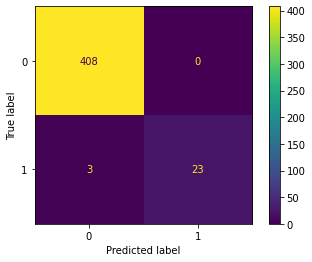

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cf_matrix = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(cf_matrix)
disp.plot()
plt.show()

#### Roc curves and Area Under Curve (AUC)

gamma = 0.01  accuracy = 0.96   AUC = 1.00
gamma = 0.10  accuracy = 0.94   AUC = 0.99
gamma = 0.20  accuracy = 0.94   AUC = 0.99
gamma = 1.00  accuracy = 0.94   AUC = 0.84


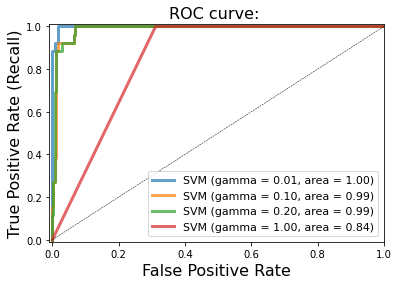

In [ ]:
from sklearn.metrics import roc_curve, auc

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
for g in [0.01, 0.1, 0.20, 1]:
    clf = svm.SVC(C=1, gamma=g, kernel='rbf', random_state=0).fit(X_train, y_train)
    y_score = clf.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    accuracy = clf.score(X_test, y_test)
    print("gamma = {:.2f}  accuracy = {:.2f}   AUC = {:.2f}".format(g, accuracy, 
                                                                    roc_auc))
    plt.plot(fpr, tpr, lw=3, alpha=0.7, 
             label='SVM (gamma = {:0.2f}, area = {:0.2f})'.format(g, roc_auc))

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate (Recall)', fontsize=16)
plt.plot([0, 1], [0, 1], color='k', lw=0.5, linestyle='--')
plt.legend(loc="lower right", fontsize=11)
plt.title('ROC curve: ', fontsize=16)
#plt.axes().set_aspect('equal')

plt.show()

In [ ]:
# Tendency
'''
def trend(arr):
    """This function calculates the trend with the unique loopback option for this type of calculation

    This tendency is not make for frame form, for this reason the equation is this: register(i)/last_register
    where "i" is the position of a register

    Note: I calculate the first tendency how last_register/last_register = 1, 
    this data appear in all first values of all rows in the slide window
    """
    t = [arr[-i]/arr[-1] for i in range(1, len(arr)+1)]
    #mean[::-1]/mean[-1]
    #for i in range(1,len(array)+1):
    #    t.append(array[-i]/array[-1])
    return np.array(t)

variables_trend = np.apply_along_axis(trend, axis=2, arr=measured_variables)
variables_trend = variables_trend.reshape(variables_trend.shape[0], variables_trend.shape[1]*ws)   # Son 20 para la speed y 20 para la accY
print("\nSample of sliding window process for tendency")
print("Tendency slide window shape: ", variables_trend.shape)
print("Tendency:\n {}".format(variables_trend[0:2,:]))
'''

'\ndef trend(arr):\n    """This function calculates the trend with the unique loopback option for this type of calculation\n\n    This tendency is not make for frame form, for this reason the equation is this: register(i)/last_register\n    where "i" is the position of a register\n\n    Note: I calculate the first tendency how last_register/last_register = 1, \n    this data appear in all first values of all rows in the slide window\n    """\n    t = [arr[-i]/arr[-1] for i in range(1, len(arr)+1)]\n    #mean[::-1]/mean[-1]\n    #for i in range(1,len(array)+1):\n    #    t.append(array[-i]/array[-1])\n    return np.array(t)\n\nvariables_trend = np.apply_along_axis(trend, axis=2, arr=measured_variables)\nvariables_trend = variables_trend.reshape(variables_trend.shape[0], variables_trend.shape[1]*ws)   # Son 20 para la speed y 20 para la accY\nprint("\nSample of sliding window process for tendency")\nprint("Tendency slide window shape: ", variables_trend.shape)\nprint("Tendency:\n {}".for

In [ ]:
# tendency
'''
def means_loopback(array):
    """This functions calculate the means with loop back option
    """
    means = []
    for i in range(1,len(array)+1):
        means.append(array[-i:].mean())
    return np.array(means)

print("data to get loop back mean: \n", measured_variables[0:2,:,:])
# mean loopback test
mean_lb = np.apply_along_axis(means_loopback, 2, measured_variables[0:2,:,:])
print("Mean loopback: \n",mean_lb)
'''

'\ndef means_loopback(array):\n    """This functions calculate the means with loop back option\n    """\n    means = []\n    for i in range(1,len(array)+1):\n        means.append(array[-i:].mean())\n    return np.array(means)\n\nprint("data to get loop back mean: \n", measured_variables[0:2,:,:])\n# mean loopback test\nmean_lb = np.apply_along_axis(means_loopback, 2, measured_variables[0:2,:,:])\nprint("Mean loopback: \n",mean_lb)\n'